In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.contrib import rnn

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
tsla_data = pd.read_csv("TSLA.csv")
print (tsla_data.head())
print (tsla_data.describe())
print (tsla_data.columns)

         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
              Open         High          Low        Close    Adj Close  \
count  2227.000000  2227.000000  2227.000000  2227.000000  2227.000000   
mean    177.031657   180.102061   173.770638   177.027750   177.027750   
std     115.239830   117.016903   113.324238   115.242084   115.242084   
min      16.139999    16.629999    14.980000    15.800000    15.800000   
25%      33.280000    34.040001    32.740000    33.375000    33.375000   
50%     206.500000   209.820007   203.000000   206.660004   206.660004   
75%     263.429993   267.070007 

In [4]:
google_data = pd.read_csv("GOOGL.csv")
print (google_data.head())
print (google_data.describe())
print (google_data.columns)

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  50.050049  52.082081  48.028027  50.220219  50.220219  44659000
1  2004-08-20  50.555557  54.594593  50.300301  54.209209  54.209209  22834300
2  2004-08-23  55.430431  56.796795  54.579578  54.754753  54.754753  18256100
3  2004-08-24  55.675674  55.855854  51.836838  52.487488  52.487488  15247300
4  2004-08-25  52.532532  54.054054  51.991993  53.053055  53.053055   9188600
              Open         High          Low        Close    Adj Close  \
count  3702.000000  3702.000000  3702.000000  3702.000000  3702.000000   
mean    463.270239   467.445276   458.695285   463.161700   463.161700   
std     313.816822   316.273918   311.171360   313.871624   313.871624   
min      49.644646    50.920921    48.028027    50.055054    50.055054   
25%     235.250244   237.389893   232.680176   235.427933   235.427933   
50%     309.799805   312.379883   307.484985   309.527039   309.527039   
75%     

In [5]:
dji_data = pd.read_csv("DJI.csv")
print (dji_data.head())
print (dji_data.describe())
print (dji_data.columns)

         Date         Open         High          Low        Close  \
0  1985-01-29  1277.719971  1295.489990  1266.890015  1292.619995   
1  1985-01-30  1297.369995  1305.099976  1278.930054  1287.880005   
2  1985-01-31  1283.239990  1293.400024  1272.640015  1286.770020   
3  1985-02-01  1276.939941  1286.109985  1269.770020  1277.719971   
4  1985-02-04  1272.079956  1294.939941  1268.989990  1290.079956   

     Adj Close    Volume  
0  1292.619995  13560000  
1  1287.880005  16820000  
2  1286.770020  14070000  
3  1277.719971  10980000  
4  1290.079956  11630000  
               Open          High           Low         Close     Adj Close  \
count   8636.000000   8636.000000   8636.000000   8636.000000   8636.000000   
mean    9497.780255   9555.735674   9438.250519   9500.461189   9500.461189   
std     6095.931494   6121.204237   6069.004934   6096.591724   6096.591724   
min     1243.709961   1251.209961   1235.530029   1242.050049   1242.050049   
25%     3565.875000   3575.7

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [6]:
def select_and_normalize_df(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = df['Open'].values
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    return scaled_data

tsla_data = select_and_normalize_df(tsla_data)
google_data = select_and_normalize_df(google_data)
dji_data = select_and_normalize_df(dji_data)

# TESLA

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [13]:
window_size = 28
inputs = []
targets = []
i = 0
while (i+window_size) <= len(tsla_data)-1:
    inputs.append(tsla_data[i:i+window_size])
    targets.append(tsla_data[i+window_size])
    i += 1

inputs = np.array(inputs)
targets = np.array(targets)

test_size = int(np.round(0.15 * inputs.shape[0]))
valid_size = int(np.round(0.15 * inputs.shape[0]))
train_size = tsla_data.shape[0] - test_size - valid_size

x_train = inputs[:train_size]
y_train = targets[:train_size]

x_valid = inputs[train_size:train_size+valid_size]
y_valid = targets[train_size:train_size+valid_size]
 
x_test = inputs[train_size+valid_size:]
y_test = targets[train_size+valid_size:]

In [14]:
print (x_train.shape)
print (y_train.shape)

print (x_test.shape)
print (y_test.shape)

(1567, 28, 1)
(1567, 1)
(302, 28, 1)
(302, 1)


# TesnorFlow Model

In [15]:
NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001
num_layers = 4
rnn_size = 150
cell_type = 'gru'
keep_prob = 0.8
use_dropout = True

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, window_size, 1], name='X')
Y = tf.placeholder(tf.float32, [None, 1], name='Y')


weights = tf.get_variable("weights_last_layer", [rnn_size, 1])
biases = tf.get_variable("bias_last_layer", [1])


if cell_type == 'rnn':
    cell_fn = rnn.BasicRNNCell
elif cell_type == 'lstm':
    cell_fn = rnn.BasicLSTMCell
elif cell_type == 'gru':
    cell_fn = rnn.GRUCell

    

def build_cell(rnn_size, keep_prob, use_dropout):
    cell = cell_fn(rnn_size, activation=tf.nn.elu)
    if use_dropout:
        cell = rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

cells = [build_cell(rnn_size, keep_prob, use_dropout=True) for _ in range(num_layers)]
model = rnn.MultiRNNCell(cells)
outputs, final_states = tf.nn.dynamic_rnn(model, X, dtype=tf.float32, scope='model')

flatten_outputs = outputs[:, -1, :]
logits = tf.matmul(flatten_outputs, weights) + biases

loss = tf.reduce_mean(tf.square(logits - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr) 
train_op = optimizer.minimize(loss)
                            

# Training

In [16]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_EPOCHS):
        train_losses = []
        b = 0
        while(b + BATCH_SIZE) <= len(x_train):
            x_batch = x_train[b:b+BATCH_SIZE]
            y_batch = y_train[b:b+BATCH_SIZE]
            
            train_loss, _ = sess.run([loss, train_op], feed_dict={X: x_batch, Y: y_batch})
            b += BATCH_SIZE
            train_losses.append(train_loss)
        val_loss = sess.run(loss, feed_dict={X: x_valid, Y: y_valid})
        print ("Epoch {}, training_loss = {:.5f}, valid_loss = {:.5f}".format(i, np.mean(train_losses), val_loss))
        
        pred_train = sess.run(logits, feed_dict={X: x_train})
        pred_valid = sess.run(logits, feed_dict={X: x_valid})
        pred_test = sess.run(logits, feed_dict={X: x_test})

Epoch 0, training_loss = 0.03586, valid_loss = 0.09233
Epoch 1, training_loss = 0.04393, valid_loss = 0.05973
Epoch 2, training_loss = 0.03373, valid_loss = 0.04390
Epoch 3, training_loss = 0.02907, valid_loss = 0.02153
Epoch 4, training_loss = 0.00786, valid_loss = 0.01241
Epoch 5, training_loss = 0.00738, valid_loss = 0.00937
Epoch 6, training_loss = 0.00334, valid_loss = 0.00987
Epoch 7, training_loss = 0.00363, valid_loss = 0.00989
Epoch 8, training_loss = 0.00436, valid_loss = 0.01066
Epoch 9, training_loss = 0.00431, valid_loss = 0.00943
Epoch 10, training_loss = 0.00367, valid_loss = 0.00881
Epoch 11, training_loss = 0.00332, valid_loss = 0.00845
Epoch 12, training_loss = 0.00254, valid_loss = 0.00950
Epoch 13, training_loss = 0.00310, valid_loss = 0.00859
Epoch 14, training_loss = 0.00274, valid_loss = 0.01077
Epoch 15, training_loss = 0.00309, valid_loss = 0.00911
Epoch 16, training_loss = 0.00354, valid_loss = 0.00914
Epoch 17, training_loss = 0.00263, valid_loss = 0.00963
Ep

# Testing

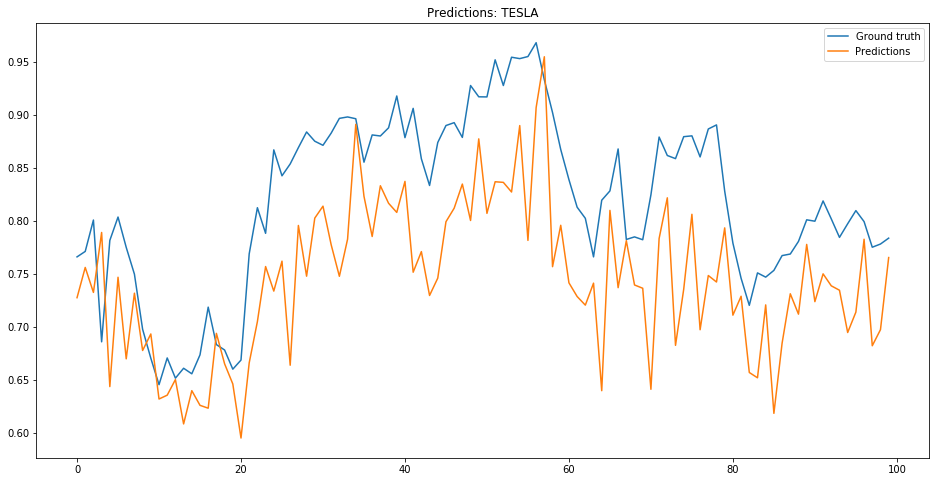

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[150:250], label='Ground truth')
plt.plot(pred_test[150:250], label='Predictions')
plt.legend()
plt.title("Predictions: TESLA")
plt.show()

# GOOGLE

In [23]:
window_size = 28
inputs = []
targets = []
i = 0
while (i+window_size) <= len(google_data)-1:
    inputs.append(google_data[i:i+window_size])
    targets.append(google_data[i+window_size])
    i += 1

inputs = np.array(inputs)
targets = np.array(targets)

test_size = int(np.round(0.15 * inputs.shape[0]))
valid_size = int(np.round(0.15 * inputs.shape[0]))
train_size = google_data.shape[0] - test_size - valid_size

x_train = inputs[:train_size]
y_train = targets[:train_size]

x_valid = inputs[train_size:train_size+valid_size]
y_valid = targets[train_size:train_size+valid_size]
 
x_test = inputs[train_size+valid_size:]
y_test = targets[train_size+valid_size:]

In [24]:
print (x_train.shape)
print (y_train.shape)

print (x_test.shape)
print (y_test.shape)

(2600, 28, 1)
(2600, 1)
(523, 28, 1)
(523, 1)


In [25]:
NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001
num_layers = 4
rnn_size = 150
cell_type = 'gru'
keep_prob = 0.8
use_dropout = True

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, window_size, 1], name='X')
Y = tf.placeholder(tf.float32, [None, 1], name='Y')


weights = tf.get_variable("weights_last_layer", [rnn_size, 1])
biases = tf.get_variable("bias_last_layer", [1])


if cell_type == 'rnn':
    cell_fn = rnn.BasicRNNCell
elif cell_type == 'lstm':
    cell_fn = rnn.BasicLSTMCell
elif cell_type == 'gru':
    cell_fn = rnn.GRUCell

    

def build_cell(rnn_size, keep_prob, use_dropout):
    cell = cell_fn(rnn_size, activation=tf.nn.elu)
    if use_dropout:
        cell = rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

cells = [build_cell(rnn_size, keep_prob, use_dropout=True) for _ in range(num_layers)]
model = rnn.MultiRNNCell(cells)
outputs, final_states = tf.nn.dynamic_rnn(model, X, dtype=tf.float32, scope='model')

flatten_outputs = outputs[:, -1, :]
logits = tf.matmul(flatten_outputs, weights) + biases

loss = tf.reduce_mean(tf.square(logits - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr) 
train_op = optimizer.minimize(loss)
                            

In [26]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_EPOCHS):
        train_losses = []
        b = 0
        while(b + BATCH_SIZE) <= len(x_train):
            x_batch = x_train[b:b+BATCH_SIZE]
            y_batch = y_train[b:b+BATCH_SIZE]
            
            train_loss, _ = sess.run([loss, train_op], feed_dict={X: x_batch, Y: y_batch})
            b += BATCH_SIZE
            train_losses.append(train_loss)
        val_loss = sess.run(loss, feed_dict={X: x_valid, Y: y_valid})
        print ("Epoch {}, training_loss = {:.5f}, valid_loss = {:.5f}".format(i, np.mean(train_losses), val_loss))
        
        pred_train = sess.run(logits, feed_dict={X: x_train})
        pred_valid = sess.run(logits, feed_dict={X: x_valid})
        pred_test = sess.run(logits, feed_dict={X: x_test})

Epoch 0, training_loss = 0.06398, valid_loss = 0.06954
Epoch 1, training_loss = 0.03931, valid_loss = 0.06186
Epoch 2, training_loss = 0.01918, valid_loss = 0.01102
Epoch 3, training_loss = 0.01200, valid_loss = 0.00975
Epoch 4, training_loss = 0.00502, valid_loss = 0.00506
Epoch 5, training_loss = 0.00307, valid_loss = 0.00325
Epoch 6, training_loss = 0.00265, valid_loss = 0.00653
Epoch 7, training_loss = 0.00382, valid_loss = 0.00615
Epoch 8, training_loss = 0.00296, valid_loss = 0.00783
Epoch 9, training_loss = 0.00417, valid_loss = 0.00786
Epoch 10, training_loss = 0.00541, valid_loss = 0.00702
Epoch 11, training_loss = 0.00587, valid_loss = 0.00464
Epoch 12, training_loss = 0.00418, valid_loss = 0.00524
Epoch 13, training_loss = 0.00338, valid_loss = 0.00692
Epoch 14, training_loss = 0.00442, valid_loss = 0.00403
Epoch 15, training_loss = 0.00349, valid_loss = 0.00488
Epoch 16, training_loss = 0.00268, valid_loss = 0.00624
Epoch 17, training_loss = 0.00273, valid_loss = 0.00575
Ep

In [27]:
y_test.shape

(523, 1)

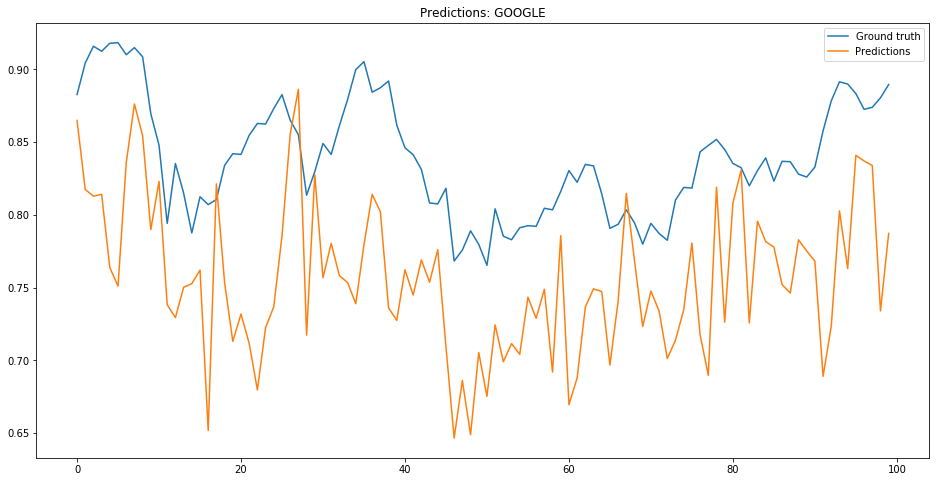

In [37]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[200:300], label='Ground truth')
plt.plot(pred_test[200:300], label='Predictions')
plt.legend()
plt.title("Predictions: GOOGLE")
plt.show()

# DJI

In [48]:
window_size = 28
inputs = []
targets = []
i = 0
while (i+window_size) <= len(dji_data)-1:
    inputs.append(dji_data[i:i+window_size])
    targets.append(dji_data[i+window_size])
    i += 1

inputs = np.array(inputs)
targets = np.array(targets)

test_size = int(np.round(0.10 * inputs.shape[0]))
valid_size = int(np.round(0.10 * inputs.shape[0]))
train_size = dji_data.shape[0] - test_size - valid_size

x_train = inputs[:train_size]
y_train = targets[:train_size]

x_valid = inputs[train_size:train_size+valid_size]
y_valid = targets[train_size:train_size+valid_size]
 
x_test = inputs[train_size+valid_size:]
y_test = targets[train_size+valid_size:]

In [49]:
print (x_train.shape)
print (y_train.shape)

print (x_test.shape)
print (y_test.shape)

(6914, 28, 1)
(6914, 1)
(833, 28, 1)
(833, 1)


In [50]:
NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001
num_layers = 4
rnn_size = 150
cell_type = 'gru'
keep_prob = 0.8
use_dropout = True

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, window_size, 1], name='X')
Y = tf.placeholder(tf.float32, [None, 1], name='Y')


weights = tf.get_variable("weights_last_layer", [rnn_size, 1])
biases = tf.get_variable("bias_last_layer", [1])


if cell_type == 'rnn':
    cell_fn = rnn.BasicRNNCell
elif cell_type == 'lstm':
    cell_fn = rnn.BasicLSTMCell
elif cell_type == 'gru':
    cell_fn = rnn.GRUCell

    

def build_cell(rnn_size, keep_prob, use_dropout):
    cell = cell_fn(rnn_size, activation=tf.nn.elu)
    if use_dropout:
        cell = rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

cells = [build_cell(rnn_size, keep_prob, use_dropout=True) for _ in range(num_layers)]
model = rnn.MultiRNNCell(cells)
outputs, final_states = tf.nn.dynamic_rnn(model, X, dtype=tf.float32, scope='model')

flatten_outputs = outputs[:, -1, :]
logits = tf.matmul(flatten_outputs, weights) + biases

loss = tf.reduce_mean(tf.square(logits - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr) 
train_op = optimizer.minimize(loss)

In [51]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_EPOCHS):
        train_losses = []
        b = 0
        while(b + BATCH_SIZE) <= len(x_train):
            x_batch = x_train[b:b+BATCH_SIZE]
            y_batch = y_train[b:b+BATCH_SIZE]
            
            train_loss, _ = sess.run([loss, train_op], feed_dict={X: x_batch, Y: y_batch})
            b += BATCH_SIZE
            train_losses.append(train_loss)
        val_loss = sess.run(loss, feed_dict={X: x_valid, Y: y_valid})
        print ("Epoch {}, training_loss = {:.5f}, valid_loss = {:.5f}".format(i, np.mean(train_losses), val_loss))
        
#         pred_train = sess.run(logits, feed_dict={X: x_train})
        pred_valid = sess.run(logits, feed_dict={X: x_valid})
        pred_test = sess.run(logits, feed_dict={X: x_test})

Epoch 0, training_loss = 0.08172, valid_loss = 0.12183
Epoch 1, training_loss = 0.02210, valid_loss = 0.04197
Epoch 2, training_loss = 0.01635, valid_loss = 0.01790
Epoch 3, training_loss = 0.01404, valid_loss = 0.01748
Epoch 4, training_loss = 0.01185, valid_loss = 0.02091
Epoch 5, training_loss = 0.00933, valid_loss = 0.02062
Epoch 6, training_loss = 0.00834, valid_loss = 0.02193
Epoch 7, training_loss = 0.00806, valid_loss = 0.02529
Epoch 8, training_loss = 0.00800, valid_loss = 0.02410
Epoch 9, training_loss = 0.00801, valid_loss = 0.02408
Epoch 10, training_loss = 0.00823, valid_loss = 0.02722
Epoch 11, training_loss = 0.00767, valid_loss = 0.02410
Epoch 12, training_loss = 0.00876, valid_loss = 0.02447
Epoch 13, training_loss = 0.00795, valid_loss = 0.01992
Epoch 14, training_loss = 0.00851, valid_loss = 0.02370
Epoch 15, training_loss = 0.00820, valid_loss = 0.01796
Epoch 16, training_loss = 0.00854, valid_loss = 0.02182
Epoch 17, training_loss = 0.00855, valid_loss = 0.01414
Ep

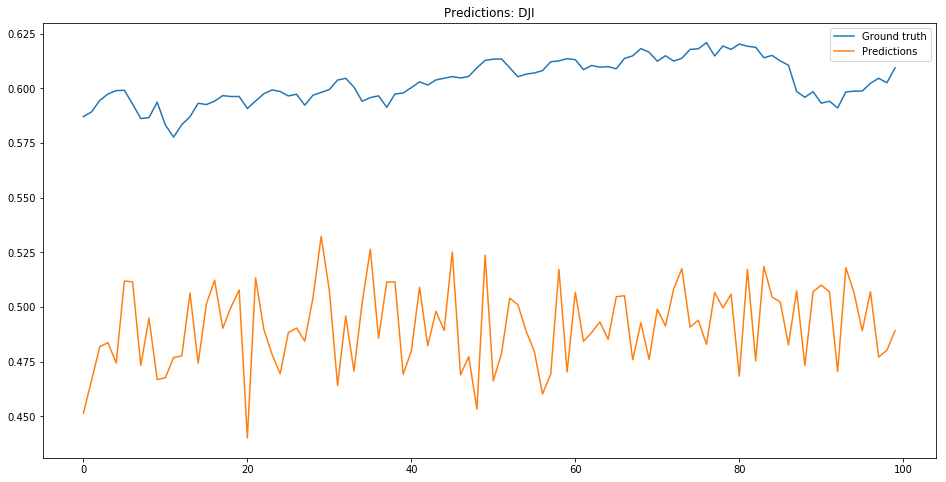

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[:100], label='Ground truth')
plt.plot(pred_test[:100], label='Predictions')
plt.legend()
plt.title("Predictions: DJI")
plt.show()